In [5]:
# Importing the libraries
import numpy as np
import pandas as pd
from sklearn.datasets import load_files
from glob import glob
import os
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline

/Users/soheil/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 1.1 Data Preprocessing - Directory

# Hyperparameters

In [6]:
img_width, img_height = 299, 299

top_model_weights_path = 'bottleneck_fc_model.h5'

train_data_dir = './dataset/Training set/'
validation_data_dir = './dataset/Validation set/'

nb_train_samples = 73499
nb_validation_samples = 10499
nb_test_samples = 20999

epochs = 50
batch_size = 32

# 1.2 Data Preprocessing - Directly

In [3]:
# Loading the csv
data_feature_label_dropped = pd.read_csv('./data_feature_label_dropped.csv')

In [4]:
data_feature_label_dropped.head()

,Unnamed: 0,Image Index,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,0,00000001_000.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,00000001_001.png,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2,00000001_002.png,1,0,1,0,0,0,0,0,0,0,0,0,0,0
3,3,00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,00000003_000.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [5]:
data_feature_label_dropped = data_feature_label_dropped.drop(['Unnamed: 0'], axis=1)

In [6]:
shuffled_data = data_feature_label_dropped.sample(frac=1, random_state = 0)
shuffled_data.head(10)

,Image Index,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
103240,00027530_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4770,00001278_009.png,0,0,1,0,0,0,0,0,0,0,0,0,0,0
33486,00008775_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0
55692,00013931_003.png,0,0,0,0,1,1,0,1,0,0,0,0,0,0
36275,00009579_001.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43871,00011311_003.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0
97419,00025696_003.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42920,00011061_002.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20342,00005440_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0
76247,00018717_001.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
index_70_percent = int(len(shuffled_data.iloc[:, 0])*0.7)
index_10_percent = int(len(shuffled_data.iloc[:, 0])*0.1) + index_70_percent
index_20_percent = int(len(shuffled_data.iloc[:, 0])*0.2) + index_10_percent

train_files, train_targets = shuffled_data.iloc[:index_70_percent, 0], shuffled_data.iloc[:index_70_percent, 1:]
val_files, val_targets = shuffled_data.iloc[index_70_percent : index_10_percent, 0], shuffled_data.iloc[index_70_percent : index_10_percent, 1:]
test_files, test_targets = shuffled_data.iloc[index_10_percent : index_20_percent, 0], shuffled_data.iloc[index_10_percent : index_20_percent, 1:]

In [8]:
print('Total number of training set: ', len(shuffled_data.iloc[:index_70_percent, 0]))
print('Total number of validation set: ', len(shuffled_data.iloc[index_70_percent : index_10_percent, 0]))
print('Total number of test set: ', len(shuffled_data.iloc[index_10_percent : index_20_percent, 0]))
print('---------------------------------------')
print('Total number of dataset: ', len(np.hstack([train_files, val_files, test_files])))

Total number of training set:  73499
Total number of validation set:  10499
Total number of test set:  20999
---------------------------------------
Total number of dataset:  104997


In [ ]:
# Saving the files
np.save("./train_files.npy", train_files)
np.save("./train_targets.npy", train_targets)

np.save("./validation_files.npy", validation_files)
np.save("./validation_targets.npy", validation_targets)

np.save("./test_files.npy", test_files)
np.save("./test_targets.npy", test_targets)

In [ ]:
# Loading the files
train_files = np.load("./train_files.npy")
train_targets = np.load("./train_targets.npy")

validation_files = np.load("./validation_files.npy")
validation_targets = np.load("./validation_targets.npy")

test_files = np.load("./test_files.npy")
test_targets = np.load("./test_targets.npy")

In [10]:
from keras.preprocessing import image
from tqdm import tqdm

def path_to_tensor(img_path):
    img = image.load_img('./Image Dataset/Total image/' + str(img_path), target_size = (img_width, img_height)) #TODO: finalize the path name
    x = image.img_to_array(img)
    return np.expand_dims(x, axis = 0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [13]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')
valid_tensors = paths_to_tensor(val_files).astype('float32') 
test_tensors = paths_to_tensor(test_files).astype('float32')

100%|██████████| 20999/20999 [05:53<00:00, 59.42it/s]


# Tensors 299x299 - Augmented and not Augmented

In [14]:
# Saving the tensros
np.save('./Tensors/training_tensor_299x299.npy', train_tensors)
np.save('./Tensors/validation_tensor_299x299.npy', valid_tensors)
np.save('./Tensors/test_tensor_299x299.npy', test_tensors)

In [11]:
# Loading the tensors
train_tensors = np.load('./Tensors/training_tensor_299x299.npy')
valid_tensors = np.load('./Tensors/validation_tensor_299x299.npy')
test_tensors = np.load('./Tensors/test_tensor_299x299.npy')

# Tensors 224x224 - Augmented and not Augmented

In [ ]:
# Saving the tensros
np.save('training_tensor_224x224.npy', train_tensors)
np.save('validation_tensor_224x224.npy', valid_tensors)
np.save('test_tensor_224x224.npy', test_tensors)

In [ ]:
# Loading the tensors
train_tensors = np.load('training_tensor_224x224.npy')
valid_tensors = np.load('validation_tensor_224x224.npy')
test_tensors = np.load('test_tensor_224x224.npy')

# Training fine tunned models

# MobileNet

In [7]:
# Importing the libraries
from keras.models import Model
from keras.applications.mobilenet import MobileNet
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, AveragePooling2D, BatchNormalization
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.initializers import glorot_normal
from keras.layers import Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications # Better alternative for applications
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import optimizers

In [130]:
# The base model
base_model = MobileNet(include_top= False, weights= None)

In [131]:
# Top model 
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(units = 14, activation = 'softmax')(x)

In [132]:
# integrating the base model and the top model
model = Model(inputs = base_model.input, outputs = predictions)

In [9]:
# Alternative

#from keras.applications.mobilenet import MobileNet
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, AveragePooling2D

base_model = MobileNet(include_top = False, weights = None)
model = Sequential()
model.add(AveragePooling2D((4,4), input_shape = (299, 299, 3))) # (train_tensors.shape[1:])
model.add(BatchNormalization())
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Dense(14, activation = 'sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d_1 (Average (None, 74, 74, 3)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 74, 74, 3)         12        
_________________________________________________________________
mobilenet_1.00_None (Model)  multiple                  3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                65600     
_________________________________________________________________
dense_2 (Dense)              (None, 14)                910       
Total para

In [14]:
print("==> Length of the base model: {}".format(len(base_model.layers)))
print("==> Length of the top model: {}".format(len(base_model.layers) - len(model.layers)))
print("==> Length of the whole model: {}".format(len(model.layers)))

==> Length of the base model: 96
==> Length of the top model: 89
==> Length of the whole model: 7


In [ ]:
# Freezing the weights of wanted layers
for layer in model.layers[:200]:
    layer.trainable = False
for layer in model.layers[200:]:
    layer.trainable = True

In [15]:
# Freezing the weights of wanted layers
for layer in model.layers:
    layer.trainable = True

In [10]:
# Compiling the model
model.compile(optimizer = 'rmsprop', 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# Training only the top model (because its weights randomely initialized)

# Define the generator for desired augmentation
datagen = ImageDataGenerator(rescale=1./255,
                             horizontal_flip=True)

# Fitting to the training set
datagen.fit(train_tensors)

# Check point
checkpointer = ModelCheckpoint(filepath='./saved models/weights.best.MobileNet_new.hdf5', 
                               verbose=1, 
                               save_best_only=True)

# Fitting the model
model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=16),
                    steps_per_epoch=len(train_tensors) / 16, 
                    validation_data = (test_tensors, test_targets), # instead of validation set, test set has been used.
                    epochs=epochs,
                    callbacks=[checkpointer], 
                    verbose=1)

Epoch 1/50
4594/4593 [==============================] - 1631s 355ms/step - loss: 0.1837 - acc: 0.9480 - val_loss: 0.2436 - val_acc: 0.9482

Epoch 00001: val_loss improved from inf to 0.24364, saving model to ./saved models/weights.best.MobileNet_new.hdf5
Epoch 2/50
4594/4593 [==============================] - 1610s 350ms/step - loss: 0.1767 - acc: 0.9485 - val_loss: 0.2015 - val_acc: 0.9482

Epoch 00002: val_loss improved from 0.24364 to 0.20149, saving model to ./saved models/weights.best.MobileNet_new.hdf5
Epoch 3/50
4594/4593 [==============================] - 1616s 352ms/step - loss: 0.1749 - acc: 0.9485 - val_loss: 0.1868 - val_acc: 0.9482

Epoch 00003: val_loss improved from 0.20149 to 0.18676, saving model to ./saved models/weights.best.MobileNet_new.hdf5
Epoch 4/50
4594/4593 [==============================] - 1617s 352ms/step - loss: 0.1738 - acc: 0.9483 - val_loss: 0.1900 - val_acc: 0.9482

Epoch 00004: val_loss did not improve
Epoch 5/50
4594/4593 [===========================

##### Loading the model

In [11]:
# Loading the top model's weight
model.load_weights('./saved models/weights.best.MobileNet_new.hdf5')

##### Test the model

In [ ]:
# Calculate classification accuracy on the test dataset.
Inception_prediction = [np.argmax(model.predict(np.expand_dims(feature, axis = 0))) for feature in valid_tensors]

test_accuracy = 100 * np.sum(np.array(Inception_prediction) == np.argmax(val_targets, axis = 1)) // len(Inception_prediction)

print("Test Accuracy: {}%".format(test_accuracy))

In [ ]:
score = model.evaluate(x = valid_tensors, y = val_targets, verbose=0)
print('\nMobileNet - accuracy:', score[1],'\n')

In [120]:
val_targets_list = []
for i in val_targets:
    val_targets_list.append(i)
val_targets_list = np.array(val_targets_list)

In [ ]:
# Calculate classification accuracy on the test dataset.
mobilenet_prediction_14_percentage = [model.predict(np.expand_dims(feature, axis = 0)) for feature in valid_tensors]
mobilenet_prediction = [np.argmax(model.predict(np.expand_dims(feature, axis = 0))) for feature in valid_tensors]

test_accuracy = 100 * np.sum(np.array(mobilenet_prediction) == np.argmax(val_targets_list, axis = 1)) // len(mobilenet_prediction)

print("Test Accuracy: {}%".format(test_accuracy))

In [111]:
mobilenet_prediction_14_percentage

[array([[0.01582403, 0.02393439, 0.12833016, 0.00018343, 0.16500703,
         0.08666586, 0.06709624, 0.09235406, 0.07737052, 0.06020791,
         0.00681595, 0.02218645, 0.00517591, 0.03812751]], dtype=float32),
 array([[0.01486662, 0.02384865, 0.12611684, 0.00017378, 0.16029105,
         0.08828958, 0.0672256 , 0.08935049, 0.07865432, 0.06136185,
         0.00635011, 0.02258589, 0.00449653, 0.0361212 ]], dtype=float32),
 array([[0.01535739, 0.02387263, 0.11935285, 0.00017587, 0.16114451,
         0.08686334, 0.06699972, 0.08638815, 0.07803798, 0.06023959,
         0.00646691, 0.0224355 , 0.0048181 , 0.03598706]], dtype=float32),
 array([[0.01635797, 0.02486677, 0.13357517, 0.0002046 , 0.16661246,
         0.08866917, 0.06840765, 0.09596112, 0.07932586, 0.06174978,
         0.00717157, 0.02300266, 0.00539417, 0.03948408]], dtype=float32),
 array([[0.01579178, 0.02435605, 0.13608387, 0.00018761, 0.16593024,
         0.08882971, 0.06774042, 0.09548195, 0.07928332, 0.06202945,
         0

In [108]:
data_feature_label_dropped.columns[2:]

Index(['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration',
       'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening',
       'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation'],
      dtype='object')

##### Predicting on the new images

In [35]:
# Importing the libraries
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, AveragePooling2D
from keras.models import Model
from keras.applications.mobilenet import MobileNet
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, AveragePooling2D, BatchNormalization
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.initializers import glorot_normal
from keras.layers import Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications # Better alternative for applications
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import optimizers
from keras.preprocessing import image
from tqdm import tqdm

def chest_xray_model():
    base_model = MobileNet(include_top = False, weights = None)
    model = Sequential()
    model.add(AveragePooling2D((4,4), input_shape = (299, 299, 3))) #TODO: later change this to a number
    model.add(BatchNormalization())
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(64))
    model.add(Dense(14, activation = 'sigmoid'))

    # Compiling the model
    model.compile(optimizer = 'rmsprop', 
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'])
    
    model.load_weights('./saved models/weights.best.MobileNet_new.hdf5')
    
    return model

In [36]:
# Write a function that takes a path to an image as input and returns the chest illness that is predicted by the model.

def chest_xray_predict(img_path):
    # Converting a image file path to a tensor
    img_width, img_height = 299, 299
    img = image.load_img(str(img_path), target_size = (img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    img = img.astype('float32')
    
    # Prediction
    prediction = chest_xray_model().predict(img)
    
    # Chest Ilness names
    illness_names = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration','Mass', 'Nodule', 
                     'Atelectasis', 'Pneumothorax', 'Pleural_Thickening','Pneumonia', 'Fibrosis', 'Edema', 
                     'Consolidation'] 

    # Making a dictionary of illness name and their prediction percentage
    prediction_dict = {}
    for index, i in enumerate(prediction[0]):
        prediction_dict[illness_names[index]] = i
    
    # Sorting the prediction from top to bottom
    import operator
    sorted_prediction = sorted(prediction_dict.items(), key=operator.itemgetter(1), reverse=True)
    
    return sorted_prediction

In [32]:
val_files

25489     00006703_007.png
3611      00000978_000.png
81863     00020142_000.png
58081     00014368_002.png
17408     00004676_000.png
48935     00012403_000.png
94814     00024540_000.png
63093     00015605_001.png
82681     00020326_031.png
25147     00006626_001.png
49742     00012622_028.png
39661     00010363_001.png
104563    00027977_000.png
92014     00022964_000.png
82489     00020290_009.png
98396     00025997_006.png
102019    00027151_000.png
13224     00003436_007.png
78788     00019339_001.png
29964     00007803_000.png
9595      00002492_011.png
24581     00006463_001.png
94013     00023814_000.png
82801     00020340_007.png
29612     00007708_009.png
42230     00010864_010.png
37832     00009953_002.png
10735     00002784_000.png
75717     00018591_000.png
2336      00000609_001.png
                ...       
24124     00006335_000.png
8052      00002111_015.png
39224     00010294_008.png
97856     00025825_006.png
33875     00008875_023.png
70059     00017246_000.png
8

In [168]:
prediction = chest_xray_predict('./Image Dataset/Total image/00006703_007.png')

In [169]:
prediction

[('Infiltration', 0.19541764),
 ('Atelectasis', 0.098862395),
 ('Effusion', 0.08721993),
 ('Mass', 0.07617651),
 ('Pneumothorax', 0.07523301),
 ('Nodule', 0.07330596),
 ('Consolidation', 0.03935867),
 ('Emphysema', 0.03508396),
 ('Pleural_Thickening', 0.03369551),
 ('Fibrosis', 0.017401157),
 ('Edema', 0.017310264),
 ('Cardiomegaly', 0.01637559),
 ('Pneumonia', 0.012508516),
 ('Hernia', 0.0006819311)]

In [37]:
def prediction_xray_chest(img_path, top_model_number):
    
    prediction = chest_xray_predict(img_path)
    
    for index, i in enumerate(prediction):
        print(index, i[0], "with: %", "%4.5f" % (i[1] *100), 'probability out of 14 illnesses')
        if index == (top_model_number - 1):
            break

In [206]:
prediction_xray_chest(img_path = './Image Dataset/Total image/00006703_007.png', top_model_number = 3)

0 Infiltration with: % 19.54176 probability out of 14 illnesses
1 Atelectasis with: % 9.88624 probability out of 14 illnesses
2 Effusion with: % 8.72199 probability out of 14 illnesses


In [208]:
prediction_xray_chest(img_path = './Image Dataset/Total image/00000978_000.png', top_model_number = 3)

0 Infiltration with: % 20.33172 probability out of 14 illnesses
1 Atelectasis with: % 9.01671 probability out of 14 illnesses
2 Effusion with: % 8.57425 probability out of 14 illnesses


In [209]:
prediction_xray_chest(img_path = './Image Dataset/Total image/00013391_011.png', top_model_number = 3)

0 Infiltration with: % 21.54625 probability out of 14 illnesses
1 Pneumothorax with: % 11.15172 probability out of 14 illnesses
2 Mass with: % 9.92420 probability out of 14 illnesses


0 Infiltration with: % 21.76177 probability out of 14 illnesses
1 Effusion with: % 8.77430 probability out of 14 illnesses
2 Pneumothorax with: % 8.63928 probability out of 14 illnesses
None


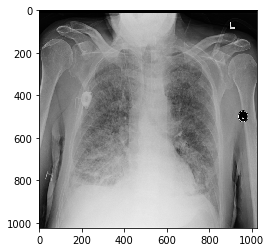

In [52]:
from PIL import Image
import cv2
# ==============================
# Choose your image
path = './Image Dataset/Image total/00000978_000.png'
# ==============================

img = cv2.imread(path)

# Loading the image
#img = Image.open(path)
plt.imshow(img)

# Detection
print(prediction_xray_chest(path, top_model_number = 3))

In [18]:
img = Image.open(path)

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline